<a href="https://colab.research.google.com/github/kyalan/DataScienceFactory/blob/master/mnist_withGPUkeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
import tensorflow as tf
from keras.datasets import mnist
import pandas as pd
import numpy as np
from datetime import datetime as dt
import sklearn.metrics
import seaborn as sns

from matplotlib import pyplot as plt
from keras import backend

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

print(tf.__version__)
print(backend.image_data_format())

2.2.0-rc2
channels_last


# Import data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

img_rows, img_cols = x_train.shape[1], x_train.shape[2]
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

print('shapes of train set: ', x_train.shape, y_train.shape)
print('shapes of test set: ', x_test.shape, y_test.shape)

n_train = x_train.shape[0]
x_dev = x_train[int(n_train*0.9):,]
x_train = x_train[:int(n_train*0.9),]
y_dev = y_train[int(n_train*0.9):,]
y_train = y_train[:int(n_train*0.9),]

n_train, n_dev, n_test = x_train.shape[0], x_dev.shape[0], x_test.shape[0]

print('no. of data for train, dev, test', n_train, n_dev, n_test)

shapes of train set:  (60000, 28, 28, 1) (60000,)
shapes of test set:  (10000, 28, 28, 1) (10000,)
no. of data for train, dev, test 54000 6000 10000


Label: 5 Image Max Value: 255


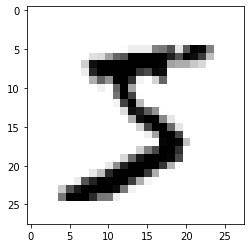

In [4]:
# check data structure
image = x_train[0,].squeeze()
label = y_train[0]

print("Label: {}".format(label), "Image Max Value: {}".format(image.max()))
plt.imshow(image, cmap=plt.cm.binary)
plt.show()

# Pre-processing

In [0]:
def preprocessor(imgs, labels):
    imgs = imgs.astype('float32')
    imgs /= 255.0
    return imgs, labels

In [0]:
x_train, y_train = preprocessor(x_train, y_train)
x_dev, y_dev = preprocessor(x_dev, y_dev)

# Modeling

In [0]:
def getModel():
    model = tf.keras.Sequential(
        [tf.keras.layers.Conv2D(16, kernel_size=3, input_shape=input_shape)
        , tf.keras.layers.Conv2D(32, kernel_size=3)
        , tf.keras.layers.Flatten()
        , tf.keras.layers.Dense(128, activation='relu')
        , tf.keras.layers.Dense(10, activation='softmax')
        ]
    )
    model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['acc'])
    return model

In [9]:
%%time

model = getModel()
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_dev, y_dev), verbose=1)

Epoch 1/5
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2024 - acc: 0.9394 - val_loss: 0.1090 - val_acc: 0.9660
Epoch 2/5
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0925 - acc: 0.9713 - val_loss: 0.0851 - val_acc: 0.9773
Epoch 3/5
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0640 - acc: 0.9803 - val_loss: 0.0858 - val_acc: 0.9785
Epoch 4/5
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0463 - acc: 0.9847 - val_loss: 0.0963 - val_acc: 0.9725
Epoch 5/5
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0342 - acc: 0.9889 - val_loss: 0.1070 - val_acc: 0.9740
CPU times: user 31.5 s, sys: 6.29 s, total: 37.8 s
Wall time: 34.8 s


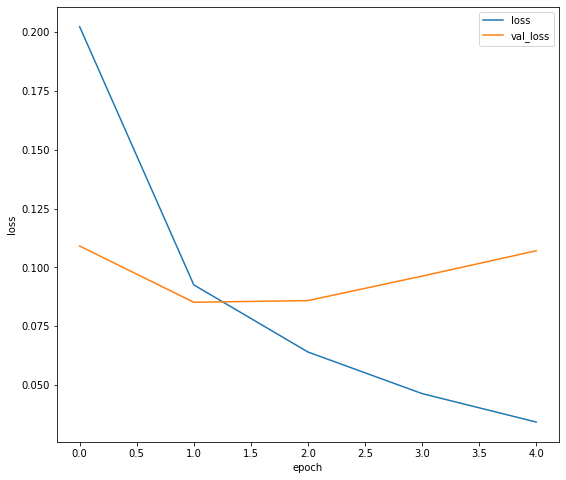

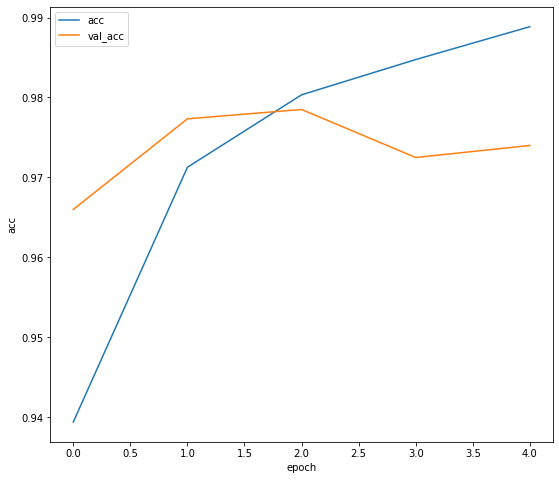

In [10]:
def plot_history(history):
    hist = history.history
    for key in ['loss', 'acc']:
        plt.figure(figsize=(9, 8))
        plt.xlabel('epoch')
        plt.ylabel(key)
        plt.plot(range(len(hist[key])), hist[key], label = key)
        plt.plot(range(len(hist['val_' + key])), hist['val_' + key], label = 'val_' + key)
        plt.legend()
    plt.show()

%matplotlib inline
plot_history(history)

# Model Evaluation

In [11]:
eval = model.evaluate(x_test, y_test)
print('Test data: Loss = {}, Accuracy = {}'.format(eval[0], eval[1]))
print('Right Prediction: {}, Wrong Prediction: {}'.format(eval[1]*n_test, (1.0-eval[1])*n_test))

313/313 [==============================] - 1s 2ms/step - loss: 23.9636 - acc: 0.9735
Test data: Loss = 23.96364402770996, Accuracy = 0.9735000133514404
Right Prediction: 9735.000133514404, Wrong Prediction: 264.9998664855957


In [13]:
%%time

test_labels = y_test
test_pred = model.predict(x_test).argmax(axis=1)

CPU times: user 385 ms, sys: 21.1 ms, total: 407 ms
Wall time: 334 ms


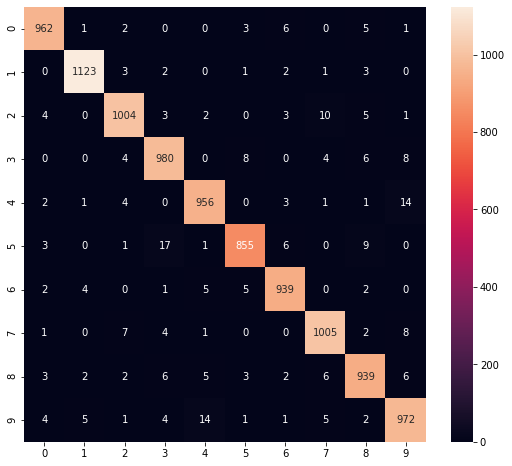

In [14]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
fig = plt.figure(figsize=(9, 8))
sns.heatmap(pd.DataFrame(cm, range(10), range(10)), annot=True, fmt='d')

Text(0.5, 1.0, 'pred: 3, real: 2')

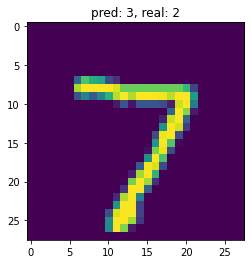

In [18]:
iimg = np.where(test_labels!=test_pred)[0][0]
img, label = x_test[0], y_test[0]

plt.imshow(img.squeeze() * 255.0)
plt.title('pred: {}, real: {}'.format(test_pred[iimg],test_labels[iimg]))